<a href="https://colab.research.google.com/github/RugiTu-13/Python-N.D./blob/main/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python for Data Analysis, GMC, Vilnius University, 2025

# HW4: Training a succesfull machine learning (ML) model

- **Tasks in this homework are built around a single data file** which should be downloaded in the Notebook as asked in the cell after the imports.
- Packages allowed to be imported (but not necessarily needed): `scikit-learn`, `numpy`, `pandas`, `matplotlib`, `seaborn`, `tqdm`, `itertools`, `math`, `string`. Do not import any other packages.
- **You will need to upload your solutions into your Github repository** dedicated for the Python for Data Analysis course. Use the same repository used for Homework 3.
- Same requirements as for Homework 3:
   - Do not write docstrings (function description comments).
   - Keep prints informative.
   - Do not create classes.
   - Do not change assert statements.

There are 5 tasks in this Notebook. They have slightly different numbers of points between them, with subpoints shown for each subtask e.g. (0.2p). You need to collect 8 points in total to get the maximum grade.

As previously, each task consists of a text cell with task description, a code cell to solve the task, and a code cell with `assert` statements to check your code for *some* possible errors.

Don't hesitate to contact me or Martynas if you are stuck.

In [1]:
# your imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans, DBSCAN

from tqdm.auto import tqdm

import urllib.request

In [2]:
# download the file using the link provided, by any method you like/understand the most,
# but the downloading process should happen inside the Notebook.
file_url = "https://github.com/Tallivm/vu-python/blob/main/hw4_2025.csv"
raw_url = file_url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")
data_filename = "hw4_2025.csv"

try:
  urllib.request.urlretrieve(raw_url, data_filename)
  print(f"File downloaded and saved as '{data_filename}'.")
except Exception as e:
 print(f"Could not download the data file automatically: {e}")
 print("If needed, download it manually and save as 'hw4_2025.csv'.")


File downloaded and saved as 'hw4_2025.csv'.


In [3]:
# Run this cell to store the name of the column to predict.
# Use this variable when needed.
TO_PREDICT = 'snail_genus'

# 🍂 Task 1 (1 point): The new challenge

Some researchers who collected data for SNAILAB complained that measuring a single sample takes a lot of time and is quite difficult. Many snails are actually found on fallen leaves, not on whole plants, making several measurements impossible to make. Moreover, if a snail hides inside its shell, for certain measurements the researcher is forced to wait until the snail fully appears again.

An intern from SNAILAB suggested that they could use AI to solve this issue. After several discussions, they decided to train a model which would **predict the genus of a snail** from only easy-to-measure features. The intern prepared some useful data but then got sick. So, SNAILAB asks for your help once more.

You will need to train several simple models to predict snail genus for a provided data set, and select the best model.

But first - the provided **data should be explored**!

1. (0.2p) Load the data as a DataFrame, name it `raw`. Make sure the "Unnamed: 0" column is not formed by providing correct parameters into the `read_csv()` function. Print out a short report (in any format you like, make it a function) using f-strings and containing this information:
   - Number of NaN values in total, and if there are NaNs, then in which columns and how many;
   - Min, mean, and max values of each numeric column;
   - Unique values and their counts of each categorical column.

2. (0.4p) According to the report, make certain changes to the data and name the result `clean`:
   - If there are NaNs, remove full rows with them;
   - Remove full rows containing seemingly incorrect measurement values (e.g. negative values for length measurements).
   - Even if these steps were not required for this data, do it nevertheless, in a way that could be applicable to any dataset with such requirements (but maybe different columns and values).

3. (0.1p) Print out the report again using the previously written function.

4. (0.3p) Obtain and visualize a Spearman correlation matrix (as a heatmap) for all numeric columns. Make sure colormap is used correctly (divergent, zero in the middle), and the plot contains column names.

===== Report for raw data =====
Total NaN values: 8
NaNs per column:
  snail_genus: 1
  leaf_width_mm: 1
  leaf_surface: 1
  shell_height_mm: 1
  shell_color: 1
  shell_radius_mm: 3

Numeric columns (min / mean / max):
  leaf_width_mm: min=1.00, mean=46.64, max=83.00
  leaf_length_mm: min=2.00, mean=62.25, max=133.00
  shell_height_mm: min=-9.00, mean=6.43, max=12.00
  shell_radius_mm: min=-7.00, mean=6.52, max=13.00

Categorical columns (value counts):
  snail_genus:
    'Flexorus': 440
    'Caracolus': 415
    'Slimospira': 403
    'Mollisphora': 391
    'Lunaspira': 381
    'Helixoda': 300
    'Spiralina': 275
  leaf_surface:
    'waxy': 968
    'smooth': 844
    'hairy': 793
  shell_color:
    'dark': 1084
    'yellow': 936
    'striped': 451
    'white': 74
    'brown': 60

Removing 2 rows with negative numeric measurements.
===== Report for clean data =====
Total NaN values: 0
No missing values detected.

Numeric columns (min / mean / max):
  leaf_width_mm: min=1.00, mean=46.63, 

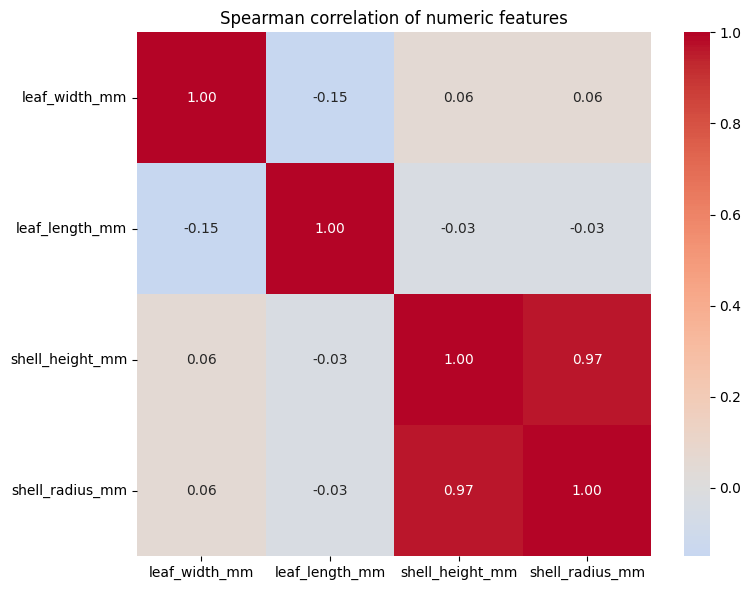

In [4]:
# your code

def print_df_report(df, name="Data"):
  print(f"===== Report for {name} =====")
  total_nans = df.isna().sum().sum()
  print(f"Total NaN values: {total_nans}")
  if total_nans > 0:
    print("NaNs per column:")
    for col, cnt in df.isna().sum().items():
      if cnt > 0:
        print(f"  {col}: {cnt}")
  else:
    print("No missing values detected.")
  print()

  numeric_cols = df.select_dtypes(include=[np.number]).columns
  if len(numeric_cols) > 0:
    print("Numeric columns (min / mean / max):")
    desc = df[numeric_cols].agg(["min", "mean", "max"])
    for col in numeric_cols:
      mn = desc.loc["min", col]
      mean = desc.loc["mean", col]
      mx = desc.loc["max", col]
      print(f"  {col}: min={mn:.2f}, mean={mean:.2f}, max={mx:.2f}")
  else:
    print("No numeric columns found.")
  print()

  cat_cols = df.select_dtypes(include=["object", "category"]).columns
  if len(cat_cols) > 0:
    print("Categorical columns (value counts):")
    for col in cat_cols:
      print(f"  {col}:")
      vc = df[col].value_counts(dropna=True)
      for val, cnt in vc.items():
        print(f"    {val!r}: {cnt}")
  else:
    print("No categorical columns found.")
  print("==============================\n")


# 1 raw data
raw = pd.read_csv(data_filename)
raw = raw.loc[:, ~raw.columns.str.contains("^Unnamed")]
print_df_report(raw, name="raw data")

# 2
clean = raw.dropna().copy()

numeric_cols = clean.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
  mask_non_negative = (clean[numeric_cols] >= 0).all(axis=1)
  removed_rows = len(clean) - mask_non_negative.sum()
  if removed_rows > 0:
    print(f"Removing {removed_rows} rows with negative numeric measurements.")
  clean = clean.loc[mask_non_negative].copy()

# 3
print_df_report(clean, name="clean data")

# 4 Spearman correlation heatmap
numeric_cols = clean.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
  corr = clean[numeric_cols].corr(method="spearman")
  plt.figure(figsize=(8, 6))
  sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
  )
  plt.title("Spearman correlation of numeric features")
  plt.tight_layout()
  plt.show()
else:
  print("Not enough numeric columns for a correlation heatmap.")


In [5]:
assert isinstance(raw, pd.DataFrame)
assert isinstance(clean, pd.DataFrame)
assert clean.isna().sum().sum() == 0
assert len(raw.columns) == len(clean.columns)
assert TO_PREDICT in raw.columns
assert TO_PREDICT in clean.columns

# 🔨 Task 2 (1 point): Data transformation and preparation for training

Next step is to prepare data for the model training. The DataFrame created during this task should be called `transformed`.

1. (0.4p) Standardize numeric columns:
   - using the `scikit-learn` package;
   - using just `numpy`;
   - Compare results and show that they are the same or similar enough. If there is any difference, notice how big it is.
2. (0.3p) Encode all categorical columns except snail genus using one-hot encoding from `pandas` or `scikit-learn`. Make sure that in the end, there are N-1 columns for a categorical column with N unique values. Make sure that old categorical columns are not left in the data.
3. (0.2p) Encode the snail genus as integer column using `pandas` or `numpy`. Make sure to create a dictionary `snail_classes` mapping snail genera and integers.
4. (0.1p) Create `X` and `y` from the whole data. The `X` should contain all columns except the snail genus column, and the `y` should contain only the snail genus column and be a `Series` object.

In [14]:
# your code
# 1 Numeric columns standartization
numeric_cols = clean.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
scaled_sklearn = scaler.fit_transform(clean[numeric_cols])

means = clean[numeric_cols].mean()
stds = clean[numeric_cols].std(ddof=0)  # population std, kaip ir StandardScaler
scaled_numpy = (clean[numeric_cols] - means) / stds

max_diff = np.abs(scaled_sklearn - scaled_numpy.values).max()
print(f"Maximum absolute difference between sklearn and numpy standardization: {max_diff:.6f}")

numeric_scaled_df = pd.DataFrame(
  scaled_sklearn,
  columns=numeric_cols,
  index=clean.index,
)

# 2 One-hot encoding
cat_cols = clean.select_dtypes(include=["object", "category"]).columns
cat_cols_to_encode = [c for c in cat_cols if c != TO_PREDICT]

other_part = clean.drop(columns=numeric_cols)

if len(cat_cols_to_encode) > 0:
  transformed = pd.concat([numeric_scaled_df, other_part], axis=1)
  transformed = pd.get_dummies(
    transformed,
    columns=cat_cols_to_encode,
    drop_first=True,
  )
else:
  transformed = pd.concat([numeric_scaled_df, other_part], axis=1)

# 3
snail_classes = {}
if TO_PREDICT in transformed.columns:
  unique_classes = sorted(transformed[TO_PREDICT].unique())
  snail_classes = {cls: idx for idx, cls in enumerate(unique_classes)}
  transformed[TO_PREDICT] = transformed[TO_PREDICT].map(snail_classes).astype(int)
else:
  raise ValueError(f"Target column {TO_PREDICT!r} not found in transformed data.")

# 4
X = transformed.drop(columns=[TO_PREDICT]).copy()
y = transformed[TO_PREDICT].copy()


Maximum absolute difference between sklearn and numpy standardization: 0.000000


In [7]:
assert isinstance(transformed, pd.DataFrame)
assert transformed.isna().sum().sum() == 0
assert len(transformed.columns) > len(clean.columns)
assert TO_PREDICT in transformed.columns
assert transformed[TO_PREDICT].dtype == int
assert str not in transformed.dtypes  # CHECK IF WORKS
assert 2 in transformed[TO_PREDICT]
assert isinstance(X, pd.DataFrame)
assert len(X.columns) == len(transformed.columns) - 1
assert isinstance(y, pd.Series)
assert isinstance(snail_classes, dict)

# 🎓 Task 3 (1 point): Model training and evaluation

Write a function named `split_and_train_model` which uses the standard model training pipeline:
- It should take `X`, `y`, `random_seed`, and a function (type `Callable`) to create the model. It should also take an optional `max_iter` parameter with default value of 300.
- Inside, it should:
   - Correctly split `X` and `y` into `X_train`, `y_train`, `X_test`, `y_test`. You can use different names but the structure should remain the same. Use test size of 20%. Use `random_seed` to fix the random state of data splitting.
   - Create an instance of the chosen model (by calling the provided function), with its random seed fixed to `random_seed` parameter.
   - Use the model to fit `X_train` and `y_train`.
   - Use the fitted model to generate predictions from `X_test`.
   - Calculate the accuracy score by comparing `y_test` and obtained predictions. Print out the score (formatted using f-string).
   - Return the trained model.
   - In case of **any** exception, do not raise it, but print out the error message and return `None` instead.

As an usage example, use this function with the data prepared in Task 2 and `LogisticRegression` from `scikit-learn`.

In [15]:
# your code

def split_and_train_model(X, y, random_seed, model_function, max_iter=300):
  try:
    X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=random_seed,
      stratify=y,
    )
    model = model_function(random_state=random_seed, max_iter=max_iter)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {acc:.4f}")
    model.training_accuracy_ = acc
    return model
  except Exception as e:
    print(f"Error while training the model: {e}")
    return None

baseline_random_seed = 42
baseline_model = split_and_train_model(
  X,
  y,
  random_seed=baseline_random_seed,
  model_function=LogisticRegression,
)

baseline_accuracy = None
if baseline_model is not None and hasattr(baseline_model, "training_accuracy_"):
  baseline_accuracy = baseline_model.training_accuracy_
  print(f"Baseline Logistic Regression accuracy: {baseline_accuracy:.4f}")
else:
  print("Baseline model was not trained successfully.")


Accuracy score: 0.6923
Baseline Logistic Regression accuracy: 0.6923


In [9]:
# no asserts there!

# 🧩 Task 4 (2 points): Feature extraction - clustering

Someone from SNAILAB theorized that knowing the genus of the plant which the leaf belongs to should help predict the genus of the snail, as certain snails are attracted to certain plants. However, the dataset does not contain plant names, and either way, plant identification requires additional time and skill.

Instead, you can use unsupervised learning to cluster plant features and use this information as a new feature.

1. (0.1p) Create a new DataFrame `plants` containing only plant features from `transformed`. Here, you are allowed to write column names manually.
2. (0.9p) You will use several clustering methods: [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html), and [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). They allow to provide different clustering parameters. Create a list `cluster_setups` containing `tuple[str, Callable, dict]` items (setups), where `str` is a short model name just for printing purposes, `Callable` is the clustering function (which you will call), and `dict` is a dictionary of 1-2 parameters to provide to that function.
   - There should be several setups for each clustering method. Use `for` loops to create those setups automatically by going through lists of possible parameters. You are allowed to write the lists manually or use `np.linspace` and similar functions:
      - For Affinity Propagation, use 2-3 different `damping` values between 0.6 and 0.9;
      - For Spectral Clustering and KMeans, use 4-5 `n_clusters` values between 3 and 20.
      - For DBSCAN, use 4-5 `eps` values between 0.1 and 0.5, and 4-5 `min_samples` values between 5 and 40 (so each DBSCAN setup had two provided parameters instead of one).
3. (1.0p) For each setup in `cluster_setups`, fit a clustering model on `plants` data and get the preidcted labels for all plants. Save the labels into a dictionary `obtained_clusters` which should be of type `dict[str, list]`, The `str` keys should be some kind of automatically generated short model descriptions (e.g. use f-string and include used parameter values in it). The `list` values should be lists of predicted cluster labels.
   - You may want to use `tqdm` at this point, as some clustering methods are slower.

In [16]:
# your code
#dataframe
plant_like_substrings = ["plant", "leaf"]

candidate_cols = [
  col
  for col in X.columns
  if any(sub in col.lower() for sub in plant_like_substrings)
]

if len(candidate_cols) == 0:
  print("Could not automatically find plant-specific columns; using all feature columns instead.")
  candidate_cols = list(X.columns)

plants = X[candidate_cols].copy()
print(f"Number of plant feature columns used: {len(plants.columns)}")

#2
cluster_setups = []

#Affinity Propagation
for damping in [0.6, 0.7, 0.8]:
  params = {"damping": damping}
  cluster_setups.append(("AffinityPropagation", AffinityPropagation, params))

#Spectral Clustering
for n_clusters in [3, 5, 8, 12, 16]:
  params = {
    "n_clusters": n_clusters,
    "assign_labels": "kmeans",
    "random_state": 42,
  }
  cluster_setups.append(("SpectralClustering", SpectralClustering, params))

#KMeans
for n_clusters in [3, 5, 8, 12, 16]:
  params = {
    "n_clusters": n_clusters,
    "n_init": 10,
    "random_state": 42,
  }
  cluster_setups.append(("KMeans", KMeans, params))

#DBSCAN
eps_values = np.linspace(0.1, 0.5, 5)
min_samples_values = [4, 5, 7, 11, 20]

for eps in eps_values:
  for min_samples in min_samples_values:
    params = {
      "eps": float(eps),
      "min_samples": min_samples,
    }
    cluster_setups.append(("DBSCAN", DBSCAN, params))

print(f"Total clustering setups prepared: {len(cluster_setups)}")

obtained_clusters = {}

#3
for method_name, model_cls, params in tqdm(cluster_setups):
  model = model_cls(**params)
  try:
    labels = model.fit_predict(plants)
  except Exception as e:
    print(f"Clustering failed for {method_name} with params {params}: {e}")
    labels = np.zeros(len(plants), dtype=int)
  feature_name = method_name + "_" + "_".join(f"{k}={v}" for k, v in params.items())
  obtained_clusters[feature_name] = list(labels)

print(f"Successfully obtained {len(obtained_clusters)} clustering feature sets.")

Number of plant feature columns used: 4
Total clustering setups prepared: 38


  0%|          | 0/38 [00:00<?, ?it/s]

Successfully obtained 38 clustering feature sets.


In [11]:
assert isinstance(plants, pd.DataFrame)
assert isinstance(cluster_setups, list)
assert isinstance(obtained_clusters, dict)
assert len(cluster_setups) == len(obtained_clusters)
assert len(cluster_setups) >= 26

# 👑 Task 5 (2 points): Using extracted features to improve the result

The only thing left now is to check which clustering setup produced a new feature (predicted plant clusters) which improves the Logistic Regression model trained in Task 3.

1. (1.0p) For each plant clustering result from Task 4, check if it improves the accuracy of logistic regression:
   - Create a new variable `XX` containing the `X` from Task 2 but joined with the new feature. If the shape of `X` was (M, N), then the shape of `XX` should be (M, N+1).
   - Using already written `split_and_train_model` function, create and fit a new logistic regression model on `XX` (`y` remains unchanged from Task 2). You may need to increase `max_iter` here. Don't forget to use the same random seed for all models.
2. (1.0p) Automatically find the feature which produced the best result from all trained Logistic Regression models. Print out its name and received accuracy score.


In [17]:
# your code
cluster_model_results = {}
cluster_accuracies = {}

for feature_name, labels in obtained_clusters.items():
  XX = X.copy()
  XX[feature_name] = labels

  model = split_and_train_model(
    XX,
    y,
    random_seed=baseline_random_seed,
    model_function=LogisticRegression,
    max_iter=1000
  )

  if model is not None and hasattr(model, "training_accuracy_"):
    acc = model.training_accuracy_
    cluster_model_results[feature_name] = model
    cluster_accuracies[feature_name] = acc
    print(f"Logistic Regression with feature '{feature_name}' accuracy: {acc:.4f}")
  else:
    print(f"Model training failed for feature '{feature_name}'.")

best_feature_name = None
best_accuracy = None

for fname, acc in cluster_accuracies.items():
  if best_accuracy is None or acc > best_accuracy:
    best_accuracy = acc
    best_feature_name = fname

if best_feature_name is not None:
  print()
  print(f"Best clustering-based feature: {best_feature_name}")
  print(f"Best accuracy: {best_accuracy:.4f}")
  if baseline_accuracy is not None:
    diff = best_accuracy - baseline_accuracy
    print(f"Improvement over baseline: {diff:+.4f}")
else:
  print("Could not determine the best feature – no successful models were trained.")

Accuracy score: 0.7442
Logistic Regression with feature 'AffinityPropagation_damping=0.6' accuracy: 0.7442
Accuracy score: 0.7577
Logistic Regression with feature 'AffinityPropagation_damping=0.7' accuracy: 0.7577
Accuracy score: 0.7462
Logistic Regression with feature 'AffinityPropagation_damping=0.8' accuracy: 0.7462
Accuracy score: 0.7846
Logistic Regression with feature 'SpectralClustering_n_clusters=3_assign_labels=kmeans_random_state=42' accuracy: 0.7846
Accuracy score: 0.7231
Logistic Regression with feature 'SpectralClustering_n_clusters=5_assign_labels=kmeans_random_state=42' accuracy: 0.7231
Accuracy score: 0.7865
Logistic Regression with feature 'SpectralClustering_n_clusters=8_assign_labels=kmeans_random_state=42' accuracy: 0.7865
Accuracy score: 0.7596
Logistic Regression with feature 'SpectralClustering_n_clusters=12_assign_labels=kmeans_random_state=42' accuracy: 0.7596
Accuracy score: 0.7635
Logistic Regression with feature 'SpectralClustering_n_clusters=16_assign_label

In [13]:
# no asserts again!